In [1]:
%load_ext autoreload
%autoreload 2

expr_path = '/home/sbanerjee/Documents/work/sparse-regression/gradvi-experiments/dsc/functions'

import numpy as np
import sys
sys.path.append(expr_path)
import simulate

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from mrashpen.utils import R_lasso
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models import mixture_gaussian as mix_gauss
from gradvi.inference import LinearRegression
from gradvi.priors import Ash

In [3]:
n = 500
p = 10000
p_causal = 5
pve = 0.6
rho = 0.9
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)

In [4]:
X.shape

(500, 10000)

In [5]:
Xtest.shape

(1000, 10000)

In [6]:
covX = np.cov(Xtest.T, bias = True)

In [7]:
np.max(covX)

1.000000000000003

In [8]:
np.diag(covX)

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
#M = np.square(np.random.normal(0, 0.1, 4000 * 4000).reshape(4000, 4000))
#M[:2000, :2000] = covX
#M[2000:, 2000:] = covX
M = covX.copy()

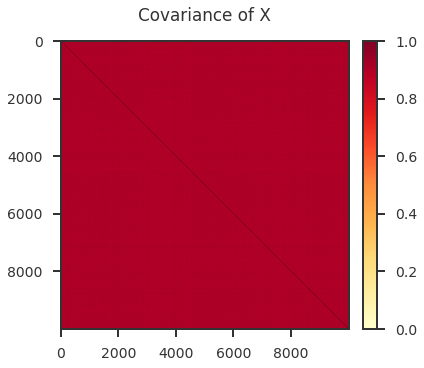

In [57]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

cmap1 = matplotlib.cm.get_cmap("YlOrRd").copy()
cmap1.set_bad("w")

norm1 = matplotlib.colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
im1 = ax1.imshow(M.T, cmap = cmap1, norm = norm1, interpolation='nearest')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)
ax1.set_title("Covariance of X", pad = 20)
plt.tight_layout()
plt.show()

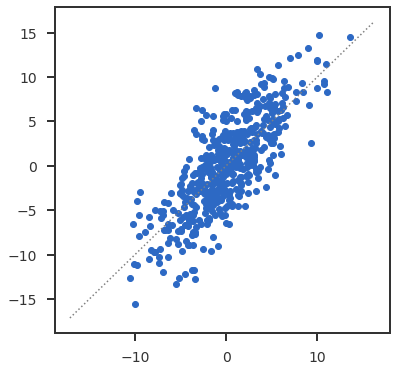

In [11]:
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, btrue), y)
mpl_utils.plot_diag(ax1)
plt.show()

In [12]:
def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk = np.abs((np.power(scale, np.arange(k) / k) - 1))
    return w, sk

wk, sk = initialize_ash_prior(k, scale = 2)

In [14]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

R[write to console]: Loading required package: Matrix



Lasso initialization


In [15]:
'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)

Mr.ASH terminated at iteration 196.


In [20]:
'''
GradVI
'''
prior = Ash(sk, wk = winit, scaled = True)
gv1 = LinearRegression()
# gv1.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)
gv1.fit(X, y, prior, s2_init = None)

In [17]:
'''
GradVI
'''
prior = Ash(sk, wk = winit, scaled = True)
gv2 = LinearRegression()
gv2.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)

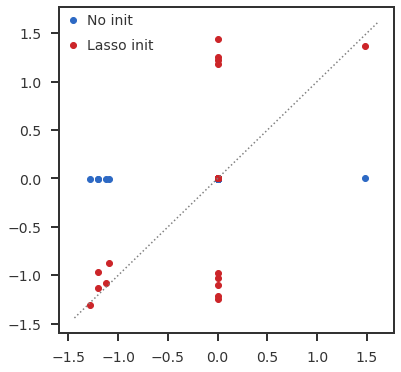

In [23]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(mrash_r.coef, gv1.coef, label = "No init")
ax1.scatter(mrash_r.coef, gv2.coef, label = "Lasso init")
ax1.legend()
mpl_utils.plot_diag(ax1)
plt.show()

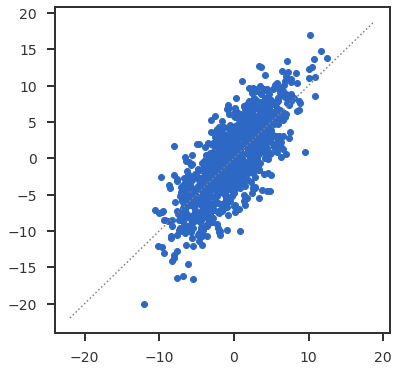

In [27]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(Xtest, gv1.coef), ytest)
mpl_utils.plot_diag(ax1)
plt.show()

In [32]:
gv2.intercept

0.10824621486671675

In [33]:
mrash_r.intercept

0.10824621486671691

In [44]:
gv1_mse = np.mean(np.square(ytest - np.dot(Xtest, gv1.coef) - gv1.intercept))
gv2_mse = np.mean(np.square(ytest - np.dot(Xtest, gv2.coef) - gv2.intercept))
mrash_r_mse = np.mean(np.square(ytest - np.dot(Xtest, mrash_r.coef) - mrash_r.intercept))
true_mse = np.mean(np.square(ytest - np.dot(Xtest, btrue)))

print ("MSE =>")
print ("No init", gv1_mse / true_mse)
print ("Lasso init", gv2_mse / true_mse)
print ("Mr.ASH", mrash_r_mse / true_mse)
print ("True", true_mse / true_mse)

MSE =>
No init 1.0331670687483578
Lasso init 1.145642663749001
Mr.ASH 1.0676774948569765
True 1.0


In [45]:
true_mse

11.10782986358233

In [56]:
np.square(strue)

10.864363807367283

In [52]:
gv1_cmse = np.mean(np.square(btrue - gv1.coef))
gv2_cmse = np.mean(np.square(btrue - gv2.coef))
mrash_r_cmse = np.mean(np.square(btrue - mrash_r.coef))
true_cmse = np.mean(np.square(btrue - btrue))

print ("Coef MSE =>")
print ("No init", gv1_cmse)
print ("Lasso init", gv2_cmse)
print ("Mr.ASH", mrash_r_cmse)

Coef MSE =>
No init 0.0004318896699635095
Lasso init 0.0021693389418530095
Mr.ASH 0.0010228282604725642


In [54]:
np.sqrt(gv1.residual_var)

3.4515048473847187

In [36]:
gv1.niter

72

In [37]:
gv2.niter

143

In [38]:
mrash_r.niter

196

In [39]:
mrash_r.elbo_path

array([1495.85073024, 1436.6193034 , 1410.11945085, 1395.7261705 ,
       1381.4761509 , 1365.51312541, 1356.94595792, 1353.0810352 ,
       1349.62887513, 1347.99787732, 1347.35359491, 1346.94102659,
       1346.61984146, 1346.36386021, 1346.15657409, 1345.98602954,
       1345.84351488, 1345.72270778, 1345.61899699, 1345.52897793,
       1345.45009926, 1345.38042078, 1345.3184474 , 1345.26301357,
       1345.21320091, 1345.16827794, 1345.1276549 , 1345.09084954,
       1345.05746077, 1345.02714887, 1344.99962052, 1344.97461789,
       1344.95191087, 1344.93129158, 1344.91257069, 1344.89557484,
       1344.88014495, 1344.86613492, 1344.8534107 , 1344.84184951,
       1344.83133909, 1344.82177703, 1344.81307016, 1344.80513387,
       1344.79789151, 1344.79127376, 1344.7852181 , 1344.77966818,
       1344.77457334, 1344.76988807, 1344.76557153, 1344.76158712,
       1344.75790205, 1344.75448696, 1344.75131554, 1344.74836425,
       1344.74561199, 1344.74303986, 1344.7406309 , 1344.73836

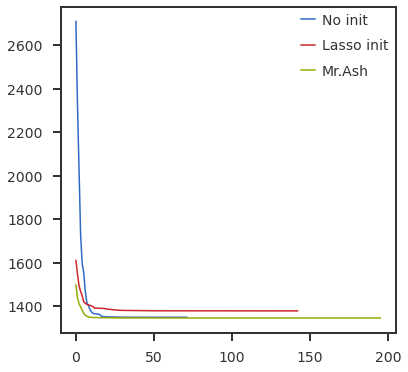

In [41]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(gv1.niter), gv1.elbo_path, label = "No init")
ax1.plot(np.arange(gv2.niter), gv2.elbo_path, label = "Lasso init")
ax1.plot(np.arange(mrash_r.niter), mrash_r.elbo_path, label = "Mr.Ash")
ax1.legend()
#mpl_utils.plot_diag(ax1)
plt.show()

In [25]:
gv2.elbo_path[-1]

208.94323968284607

In [26]:
gv1.elbo_path[-1]

207.5002481393194

In [28]:
gv1.obj_path[-1]

-5090.817118408716

In [29]:
gv2.obj_path[-1]

-5089.374126865189

In [41]:
from gradvi.models import LinearModel
model = LinearModel(
    gv1._X, gv1._y, gv1.coef, gv1.residual_var, gv1.prior,
    dj = gv1._dj, objtype = 'direct', debug = True)
model.objective

2022-06-10 15:55:06,440 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash_scaled prior
2022-06-10 15:55:06,440 | gradvi.models.linear_model               | DEBUG   | Residual variance = 0.41733286854077695


-5090.817118970594

In [48]:
from gradvi.models import LinearModel
mrash_prior = Ash(sk, wk = mrash_r.prior)
model = LinearModel(
    gv1._X, gv1._y, gv2.coef, gv2.residual_var, mrash_prior,
    dj = gv1._dj, objtype = 'direct', debug = True)
model.objective

2022-06-10 15:57:02,224 | gradvi.models.linear_model               | DEBUG   | Calculating Linear Model objective with ash_scaled prior
2022-06-10 15:57:02,225 | gradvi.models.linear_model               | DEBUG   | Residual variance = 0.4193502561477728


-5090.677734335939

In [26]:
dir(gv1)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_c_fun',
 '_dj',
 '_elbo_path',
 '_h_path',
 '_init_params',
 '_intercept',
 '_invert_method',
 '_invert_options',
 '_is_debug',
 '_is_elbo_calc',
 '_is_f_fortran',
 '_is_intercept',
 '_is_lbfgsb_fortran',
 '_is_opt_list',
 '_method',
 '_nclbk',
 '_nfev',
 '_niter',
 '_njev',
 '_objtype',
 '_opts',
 '_prior',
 '_res',
 '_v2inv',
 '_y',
 'callback',
 'coef',
 'elbo_path',
 'fit',
 'fit_fortran',
 'fit_python',
 'fitobj',
 'fun',
 'get_elbo',
 'get_model_func',
 'get_new_model',
 'grad',
 'initialize_params',
 'intercept',
 'logger',
 'nfev',
 'niter',
 'njev',
 'obj_path',
 'prior',
 'residual_var',
 'success',
 't